# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [2]:
import h2o
import os
import numpy as np
import math
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(max_mem_size='12G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,7 days 4 hours 14 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month
H2O cluster name:,H2O_from_python_ngill_vo2rw9
H2O cluster total nodes:,1
H2O cluster free memory:,10.13 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [3]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
# Ensure debt_to_income_ratio is categorical
train['debt_to_income_ratio'] = train['debt_to_income_ratio'].asfactor()
test['debt_to_income_ratio'] = test['debt_to_income_ratio'].asfactor()

In [5]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1
4.00076e+06,265000,95,1,0,285000,100,0,,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5
5.45314e+06,275000,57.9,1,0,475000,100,0,,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5
1.94229e+06,595000,80,1,0,745000,371,0,,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4


In [6]:
train.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
type,int,int,real,int,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,49.0,5000.0,1.0,0.0,0.0,5000.0,-130.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,3319386.4112125635,291981.00263194024,86.64662923818423,0.9436378151155683,5.35342838254188,358807.76858885604,152.333788621537,0.09670196709451284,,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353814,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.0030373336327
maxs,6504996.0,12005000.0,900.0,1.0,425.0,13605000.0,882000.0,1.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
sigma,1952820.8522752034,227416.2209992358,15.01109708563018,0.2306205123360138,24.864561487883368,324310.1569850146,2886.174831533794,0.295552434347859,,0.1951890799460008,0.25844393424533546,0.26936092454879995,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.48715526363003847,0.41175035739904686,0.41175035739904686,1.4115197617501203
zeros,0,0,0,9037,151301,0,982,144833,,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0
missing,0,0,0,0,0,0,0,0,74997,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0
0,2549300.0,175000.0,97.0,1.0,0.0,185000.0,36.0,0.0,47,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0
1,4000757.0,265000.0,95.0,1.0,0.0,285000.0,100.0,0.0,,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0
2,1546928.0,115000.0,97.0,0.0,120.0,125000.0,59.0,0.0,39,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0


In [7]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
131497,185000,96.5,1,0,195000,129,0,,1,1,0,1,0,0,0,1,0,1,0,nan,nan
851117,365000,95,0,85,385000,121,0,,1,1,0,1,0,0,0,0,1,1,0,nan,nan
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1
843194,365000,96.5,1,0,375000,51,1,,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1
6.37726e+06,195000,96.5,1,0,205000,54,0,,1,1,0,0,1,0,0,0,1,0,1,nan,nan
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0


In [8]:
test.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
type,int,int,real,int,int,int,int,int,enum,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,4056.0,5000.0,1.0,0.0,0.0,25000.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3323235.64242852,292912.61156774743,88.56029290647881,0.9412283798093893,5.4916040542584845,360743.028591599,182.90381221320155,0.09752407846301246,,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092
maxs,6504997.0,4625000.0,79474.0,1.0,360.0,9245000.0,396000.0,1.0,,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1954622.3871122967,224087.83385259155,398.9005406950038,0.23519972706038758,24.4766458606141,321800.26166856906,3600.669509692802,0.29667381367158185,,0.19551834219733183,0.2614461483363615,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798
zeros,0,0,0,2331,37331,0,231,35794,,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431
missing,0,0,0,0,0,0,0,0,18562,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582
0,131497.0,185000.0,96.5,1.0,0.0,195000.0,129.0,0.0,,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan
1,851117.0,365000.0,95.0,0.0,85.0,385000.0,121.0,0.0,,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan
2,835616.0,265000.0,96.28,1.0,0.0,265000.0,106.0,0.0,49,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0


In [9]:
# Inputs and output
X = ['loan_amount', 'loan_to_value_ratio', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', "debt_to_income_ratio", "term_360", "conforming"]
fold_column = 'cv_fold'
Y = "high_priced"

In [10]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [11]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [12]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [13]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [14]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [15]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount,-0.123545
loan_to_value_ratio,0.190882
no_intro_rate_period,0.018108
intro_rate_period,-0.031716
property_value,-0.137319
income,-0.007911
debt_to_income_ratio,0.031007
term_360,0.052448
conforming,0.074543


In [16]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[X + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
del mono_constraints['debt_to_income_ratio']
mono_constraints

{'loan_amount': -1,
 'loan_to_value_ratio': 1,
 'no_intro_rate_period': 1,
 'intro_rate_period': -1,
 'property_value': -1,
 'income': -1,
 'term_360': 1,
 'conforming': 1}

In [17]:
# Default GBM
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [18]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_28313


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,15676.0,5.0,5.0,5.0,14.0,28.0,20.26




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07752043996136684
RMSE: 0.27842492697559756
LogLoss: 0.2647595398015099
Mean Per-Class Error: 0.2581603561234854
AUC: 0.7985161210467326
pr_auc: 0.27079320515609845
Gini: 0.5970322420934653

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17854260903985114: 


,,0,1,Error,Rate
0,0,116714.0,28119.0,0.1941,(28119.0/144833.0)
1,1,5908.0,9597.0,0.381,(5908.0/15505.0)
2,Total,122622.0,37716.0,0.2122,(34027.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.178543,0.360647,189.0
1,max f2,0.098258,0.516180,256.0
2,max f0point5,0.240378,0.301153,145.0
3,max accuracy,0.660467,0.903311,5.0
4,max precision,0.756203,1.000000,0.0
5,max recall,0.007380,1.000000,397.0
6,max specificity,0.756203,1.000000,0.0
7,max absolute_mcc,0.121275,0.302827,233.0
8,max min_per_class_accuracy,0.125335,0.735564,230.0
9,max mean_per_class_accuracy,0.098258,0.741840,256.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010172,0.381607,4.317753,4.317753,0.417535,0.446180,0.417535,0.446180,0.043921,0.043921,331.775347,331.775347
1,,2,0.022783,0.345399,3.697616,3.974497,0.357567,0.358261,0.384342,0.397515,0.046630,0.090551,269.761626,297.449657
2,,3,0.030018,0.320648,3.280609,3.807260,0.317241,0.332019,0.368170,0.381730,0.023734,0.114286,228.060937,280.726010
3,,4,0.040352,0.298089,3.519827,3.733647,0.340374,0.306900,0.361051,0.362566,0.036375,0.150661,251.982675,273.364695
4,,5,0.050088,0.268811,3.007583,3.592521,0.290839,0.279784,0.347404,0.346475,0.029281,0.179942,200.758314,259.252061
5,,6,0.100251,0.237997,2.572727,3.082243,0.248788,0.250187,0.298059,0.298295,0.129055,0.308997,157.272704,208.224317
6,,7,0.150095,0.223876,2.461046,2.875952,0.237988,0.229502,0.278110,0.275450,0.122670,0.431667,146.104599,187.595181
7,,8,0.200127,0.199642,2.276527,2.726096,0.220145,0.211748,0.263619,0.259524,0.113899,0.545566,127.652662,172.609551
8,,9,0.300016,0.131784,1.782049,2.411780,0.172328,0.166591,0.233224,0.228583,0.178007,0.723573,78.204930,141.177977
9,,10,0.400211,0.081703,1.078199,2.077912,0.104264,0.101322,0.200938,0.196722,0.108030,0.831603,7.819862,107.791169




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07770476384113918
RMSE: 0.2787557422567994
LogLoss: 0.26541686520624225
Mean Per-Class Error: 0.25905257097882795
AUC: 0.7971637674359789
pr_auc: 0.26660954655062596
Gini: 0.5943275348719579

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17641663482659764: 


,,0,1,Error,Rate
0,0,116614.0,28219.0,0.1948,(28219.0/144833.0)
1,1,5920.0,9585.0,0.3818,(5920.0/15505.0)
2,Total,122534.0,37804.0,0.2129,(34139.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.176417,0.359602,203.0
1,max f2,0.094976,0.514864,269.0
2,max f0point5,0.238792,0.299140,147.0
3,max accuracy,0.778937,0.903292,0.0
4,max precision,0.421499,0.400191,50.0
5,max recall,0.006171,1.000000,398.0
6,max specificity,0.778937,0.999993,0.0
7,max absolute_mcc,0.119769,0.301776,246.0
8,max min_per_class_accuracy,0.123604,0.735205,243.0
9,max mean_per_class_accuracy,0.094976,0.740947,269.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.386774,4.071990,4.071990,0.393769,0.455032,0.393769,0.455032,0.040761,0.040761,307.199028,307.199028
1,,2,0.020214,0.348679,3.565008,3.816074,0.344743,0.364773,0.369022,0.409471,0.036375,0.077136,256.500790,281.607446
2,,3,0.030018,0.319796,3.677257,3.770734,0.355598,0.336072,0.364637,0.385498,0.036053,0.113189,267.725678,277.073447
3,,4,0.040003,0.295717,3.436252,3.687244,0.332292,0.307706,0.356564,0.366080,0.034312,0.147501,243.625189,268.724419
4,,5,0.050026,0.271561,3.037322,3.557033,0.293715,0.282359,0.343972,0.349306,0.030442,0.177943,203.732184,255.703285
5,,6,0.100176,0.239949,2.572081,3.063944,0.248725,0.251099,0.296289,0.300142,0.128991,0.306933,157.208090,206.394366
6,,7,0.150370,0.220845,2.458056,2.861696,0.237699,0.229741,0.276732,0.276642,0.123380,0.430313,145.805555,186.169615
7,,8,0.200021,0.201361,2.303063,2.723026,0.222711,0.212548,0.263322,0.260732,0.114350,0.544663,130.306292,172.302635
8,,9,0.300016,0.132682,1.764680,2.403611,0.170648,0.165969,0.232434,0.229147,0.176459,0.721122,76.468012,140.361081
9,,10,0.400067,0.078683,1.092637,2.075755,0.105660,0.101057,0.200730,0.197114,0.109320,0.830442,9.263695,107.575494




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78158504,0.010743101,0.78185004,0.7864865,0.78552705,0.763237,0.7908247
1,auc,0.79734045,0.0038348788,0.79227763,0.8022184,0.79728305,0.7996256,0.7952975
2,err,0.21841495,0.010743101,0.21814997,0.21351351,0.21447295,0.23676302,0.20917527
3,err_count,7004.8,367.1889,6976.0,6794.0,6873.0,7642.0,6739.0
4,f0point5,0.28613478,0.009102726,0.28243783,0.29803094,0.28416678,0.27427375,0.29176465
5,f1,0.36022213,0.0068762987,0.35574436,0.37139156,0.3578436,0.35423356,0.36189756
6,f2,0.48652348,0.009619585,0.48044303,0.4926604,0.48309788,0.5,0.47641602
7,lift_top_group,4.0865927,0.3089556,4.202595,4.0882835,4.514643,3.6791666,3.948275
8,logloss,0.26542687,0.0041377684,0.26592293,0.26988852,0.262001,0.26045245,0.26886937
9,max_per_class_error,0.36406955,0.03163783,0.37304688,0.37025416,0.3698585,0.3109796,0.39620852



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-29 16:27:18,23.652 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-11-29 16:27:19,23.742 sec,1.0,0.292629,0.308302,0.784309,0.250903,3.573322,0.223971
2,,2019-11-29 16:27:19,23.814 sec,2.0,0.290287,0.301141,0.786469,0.250646,3.580671,0.220603
3,,2019-11-29 16:27:19,23.890 sec,3.0,0.288406,0.295547,0.786803,0.251183,3.621626,0.220490
4,,2019-11-29 16:27:19,23.977 sec,4.0,0.286860,0.290995,0.787425,0.251866,3.658535,0.235259
5,,2019-11-29 16:27:19,24.057 sec,5.0,0.285590,0.287242,0.787873,0.253132,3.654128,0.235683
6,,2019-11-29 16:27:19,24.138 sec,6.0,0.284560,0.284164,0.788021,0.252325,3.644617,0.234966
7,,2019-11-29 16:27:19,24.218 sec,7.0,0.283700,0.281590,0.788642,0.253630,3.636414,0.235571
8,,2019-11-29 16:27:19,24.296 sec,8.0,0.282962,0.279384,0.789231,0.255198,3.697840,0.234168
9,,2019-11-29 16:27:19,24.381 sec,9.0,0.282400,0.277611,0.790398,0.257998,3.722295,0.237941



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,6804.754883,1.000000,0.776012
1,loan_amount,873.063782,0.128302,0.099564
2,property_value,386.977997,0.056869,0.044131
3,no_intro_rate_period,338.093414,0.049685,0.038556
4,debt_to_income_ratio.44,56.902653,0.008362,0.006489
5,debt_to_income_ratio.missing(NA),52.932541,0.007779,0.006036
6,debt_to_income_ratio.49,46.369816,0.006814,0.005288
7,intro_rate_period,40.601250,0.005967,0.004630
8,conforming,29.292673,0.004305,0.003341
9,debt_to_income_ratio.48,27.959229,0.004109,0.003188



See the whole table with table.as_data_frame()


In [19]:
## Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.8033192917544545


In [20]:
## Get the AUC on the test set for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.7971637674359789


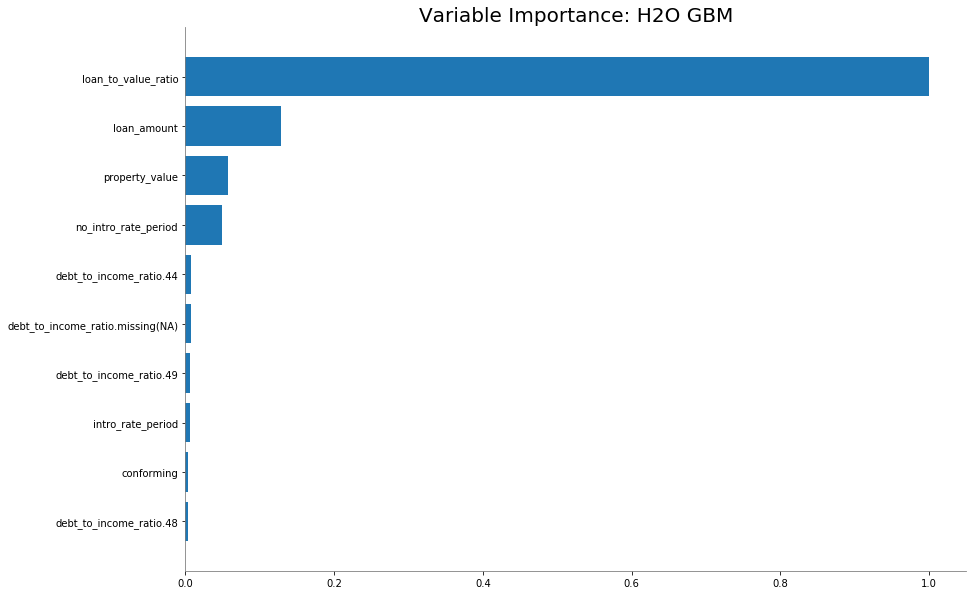

In [21]:
mgbm_default.varimp_plot()

In [22]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,term_360,conforming,debt_to_income_ratio.36,debt_to_income_ratio.37,debt_to_income_ratio.38,debt_to_income_ratio.39,debt_to_income_ratio.40,debt_to_income_ratio.41,debt_to_income_ratio.42,debt_to_income_ratio.43,debt_to_income_ratio.44,debt_to_income_ratio.45,debt_to_income_ratio.46,debt_to_income_ratio.47,debt_to_income_ratio.48,debt_to_income_ratio.49,debt_to_income_ratio.missing(NA),BiasTerm
0.149672,1.21846,0.0073409,0.0153256,0.145209,0.000552958,0.0176946,0.00206307,0.00299012,0.00280087,0.00256215,0.000151659,0.000180525,0.00100981,-0.00058722,-0.00271999,-0.0021585,-0.000160391,6.14197e-06,0.0479663,-0.000894849,0.000201235,0.0568875,-2.77627
-0.028763,0.168518,0.00428516,0.0151154,-0.0138766,0.000252224,0.0217169,0.00316391,0.00391788,0.00279125,0.00318366,-0.000202089,5.42237e-05,0.000206266,-0.000498866,-0.00203323,-0.00229458,0.000556543,-1.14249e-05,-0.00134136,-0.00161342,-0.000674278,-0.094854,-2.77627
0.171949,1.1166,-0.310329,-0.431366,0.215778,-0.00193938,0.0119978,0.00281047,0.00209362,0.00180397,0.00156071,-0.00216033,0.000182546,0.000386563,-0.000883473,-0.00200102,-0.00305085,-1.0283e-05,-0.000764732,-0.00162128,-0.000649061,0.000313349,0.049142,-2.77627
-0.0279263,-1.06863,0.00202472,0.0196301,-0.185567,0.000246224,0.0322245,0.00411257,0.00244096,0.00380458,0.00231905,0.000230099,1.96348e-05,0.000271092,-0.000653472,-0.00153769,-0.0013425,-0.000245373,0.000326134,-0.000788384,0.000308053,0.00724333,-0.051239,-2.77627
0.147512,1.21609,0.00712573,0.01533,0.144242,0.000343197,0.0170548,0.00206307,0.00298971,0.00279997,0.00256215,0.000151659,0.000181028,0.000970168,-0.000603803,-0.00292032,-0.00223355,-0.000134368,0.00253537,-0.00180163,-0.00121537,-0.000159826,0.055831,-2.77627


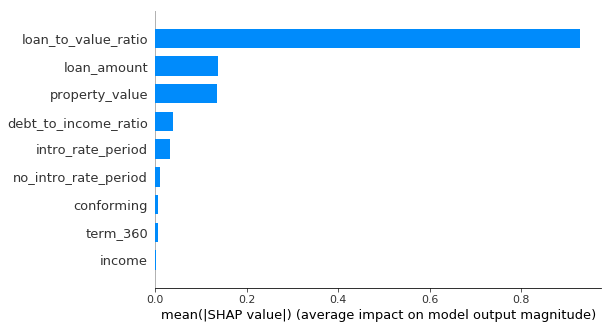

In [23]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

In [24]:
# Default XGBoost
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [25]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_28597


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07700437831775725
RMSE: 0.27749662757907034
LogLoss: 0.26229947005084747
Mean Per-Class Error: 0.2543929253100814
AUC: 0.804110979195728
pr_auc: 0.28308754952516946
Gini: 0.6082219583914561

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18662973353639245: 


,,0,1,Error,Rate
0,0,118040.0,26793.0,0.185,(26793.0/144833.0)
1,1,6101.0,9404.0,0.3935,(6101.0/15505.0)
2,Total,124141.0,36197.0,0.2052,(32894.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186630,0.363777,199.0
1,max f2,0.093340,0.520418,264.0
2,max f0point5,0.261396,0.316003,147.0
3,max accuracy,0.708210,0.903342,11.0
4,max precision,0.916047,1.000000,0.0
5,max recall,0.002628,1.000000,397.0
6,max specificity,0.916047,1.000000,0.0
7,max absolute_mcc,0.123454,0.307625,239.0
8,max min_per_class_accuracy,0.130612,0.737691,234.0
9,max mean_per_class_accuracy,0.093340,0.745607,264.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010016,0.435875,4.732673,4.732673,0.457659,0.517859,0.457659,0.517859,0.047404,0.047404,373.267291,373.267291
1,,2,0.020026,0.364054,3.923801,4.328363,0.379439,0.393476,0.418561,0.455687,0.039278,0.086682,292.380076,332.836279
2,,3,0.030211,0.339973,3.520897,4.056151,0.340478,0.351505,0.392238,0.420565,0.035859,0.122541,252.089682,305.615141
3,,4,0.040140,0.311610,3.390722,3.891552,0.327889,0.320521,0.376321,0.395818,0.033667,0.156208,239.072159,289.155161
4,,5,0.050206,0.282451,3.126662,3.738194,0.302354,0.293428,0.361491,0.375289,0.031474,0.187681,212.666234,273.819369
5,,6,0.101635,0.241684,2.633544,3.179226,0.254669,0.262022,0.307437,0.317975,0.135440,0.323122,163.354447,217.922600
6,,7,0.150033,0.220031,2.424017,2.935610,0.234407,0.229488,0.283879,0.289431,0.117317,0.440439,142.401704,193.561021
7,,8,0.200795,0.201813,2.274294,2.768427,0.219929,0.213277,0.267712,0.270179,0.115447,0.555885,127.429436,176.842742
8,,9,0.300528,0.135175,1.752501,2.431282,0.169470,0.167763,0.235110,0.236191,0.174782,0.730668,75.250134,143.128232
9,,10,0.400042,0.077597,1.057048,2.089427,0.102219,0.101397,0.202052,0.202660,0.105192,0.835859,5.704780,108.942697




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.077460709598112
RMSE: 0.2783176415502833
LogLoss: 0.2641352924722241
Mean Per-Class Error: 0.2570519002689602
AUC: 0.8005774218054201
pr_auc: 0.27409921059758185
Gini: 0.6011548436108403

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19049908120423456: 


,,0,1,Error,Rate
0,0,118491.0,26342.0,0.1819,(26342.0/144833.0)
1,1,6269.0,9236.0,0.4043,(6269.0/15505.0)
2,Total,124760.0,35578.0,0.2034,(32611.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.190499,0.361608,201.0
1,max f2,0.103024,0.517697,266.0
2,max f0point5,0.256995,0.309455,149.0
3,max accuracy,0.949757,0.903292,0.0
4,max precision,0.795154,0.421053,6.0
5,max recall,0.000884,1.000000,399.0
6,max specificity,0.949757,0.999993,0.0
7,max absolute_mcc,0.124936,0.306012,249.0
8,max min_per_class_accuracy,0.130117,0.737891,246.0
9,max mean_per_class_accuracy,0.094281,0.742948,274.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.431482,4.319516,4.319516,0.417706,0.522114,0.417706,0.522114,0.043212,0.043212,331.951643,331.951643
1,,2,0.020001,0.365102,3.999658,4.159637,0.386775,0.393961,0.402245,0.458058,0.039987,0.083199,299.965801,315.963709
2,,3,0.030005,0.340049,3.552319,3.957156,0.343516,0.352614,0.382665,0.422902,0.035537,0.118736,255.231874,295.715556
3,,4,0.040003,0.311078,3.380356,3.813001,0.326887,0.321950,0.368725,0.397672,0.033796,0.152531,238.035612,281.300066
4,,5,0.050219,0.286387,2.866201,3.620395,0.277167,0.297993,0.350099,0.377395,0.029281,0.181812,186.620102,262.039537
5,,6,0.100020,0.243551,2.656167,3.140296,0.256857,0.263262,0.303673,0.320567,0.132280,0.314092,165.616733,214.029555
6,,7,0.150002,0.220247,2.438805,2.906553,0.235837,0.229358,0.281069,0.290175,0.121896,0.435988,143.880545,190.655302
7,,8,0.200015,0.201586,2.277378,2.749230,0.220227,0.213458,0.265856,0.270992,0.113899,0.549887,127.737830,174.922991
8,,9,0.300004,0.134489,1.769950,2.422844,0.171158,0.168868,0.234294,0.236955,0.176975,0.726862,76.995039,142.284412
9,,10,0.400286,0.077072,1.071472,2.084290,0.103613,0.101030,0.201555,0.202902,0.107449,0.834312,7.147157,108.429036




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.78605485,0.012616578,0.77093625,0.79208046,0.7746677,0.79226696,0.80032283
1,auc,0.8008067,0.0038102304,0.7959835,0.80604583,0.80069065,0.80256754,0.79874605
2,err,0.21394517,0.012616578,0.22906373,0.20791955,0.22533233,0.20773306,0.19967718
3,err_count,6860.0,391.29144,7325.0,6616.0,7221.0,6705.0,6433.0
4,f0point5,0.2893308,0.010846187,0.27897233,0.30211803,0.2804351,0.28550377,0.29962486
5,f1,0.3624184,0.00801768,0.35593072,0.3740776,0.3577337,0.35683453,0.36751547
6,f2,0.48545668,0.00921474,0.4915246,0.49103373,0.4938605,0.47567898,0.4751856
7,lift_top_group,4.298369,0.20431516,4.0987425,4.3818293,4.5990286,4.1262875,4.2859564
8,logloss,0.26414356,0.0039046633,0.26480797,0.2679079,0.26063073,0.25958595,0.26778528
9,max_per_class_error,0.37142426,0.030926405,0.34114584,0.3796674,0.33826917,0.38856015,0.40947866



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-29 16:29:48,49.760 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-11-29 16:29:49,50.303 sec,1.0,0.405005,0.517472,0.790949,0.264752,3.909422,0.213175
2,,2019-11-29 16:29:49,50.669 sec,2.0,0.349888,0.422482,0.792091,0.263707,3.917860,0.213175
3,,2019-11-29 16:29:49,51.020 sec,3.0,0.318075,0.365391,0.793992,0.266584,3.936398,0.213175
4,,2019-11-29 16:29:50,51.391 sec,4.0,0.300089,0.329419,0.795630,0.267592,3.995199,0.213730
5,,2019-11-29 16:29:50,51.762 sec,5.0,0.290166,0.306312,0.796441,0.269577,4.121807,0.213081
6,,2019-11-29 16:29:50,52.122 sec,6.0,0.284772,0.291326,0.796780,0.270437,4.149538,0.209096
7,,2019-11-29 16:29:51,52.483 sec,7.0,0.281925,0.281786,0.797093,0.270874,4.183955,0.208067
8,,2019-11-29 16:29:51,52.841 sec,8.0,0.280376,0.275571,0.797488,0.270723,4.158021,0.207948
9,,2019-11-29 16:29:52,53.202 sec,9.0,0.279456,0.271449,0.797886,0.272075,4.198556,0.208004



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,24007.066406,1.000000,0.792180
1,loan_amount,3136.187500,0.130636,0.103487
2,property_value,1154.338257,0.048083,0.038091
3,no_intro_rate_period,444.588715,0.018519,0.014670
4,intro_rate_period,327.802734,0.013654,0.010817
5,income,320.280090,0.013341,0.010569
6,debt_to_income_ratio.missing(NA),181.330292,0.007553,0.005984
7,term_360,125.705978,0.005236,0.004148
8,debt_to_income_ratio.49,98.432487,0.004100,0.003248
9,debt_to_income_ratio.44,91.137421,0.003796,0.003007



See the whole table with table.as_data_frame()


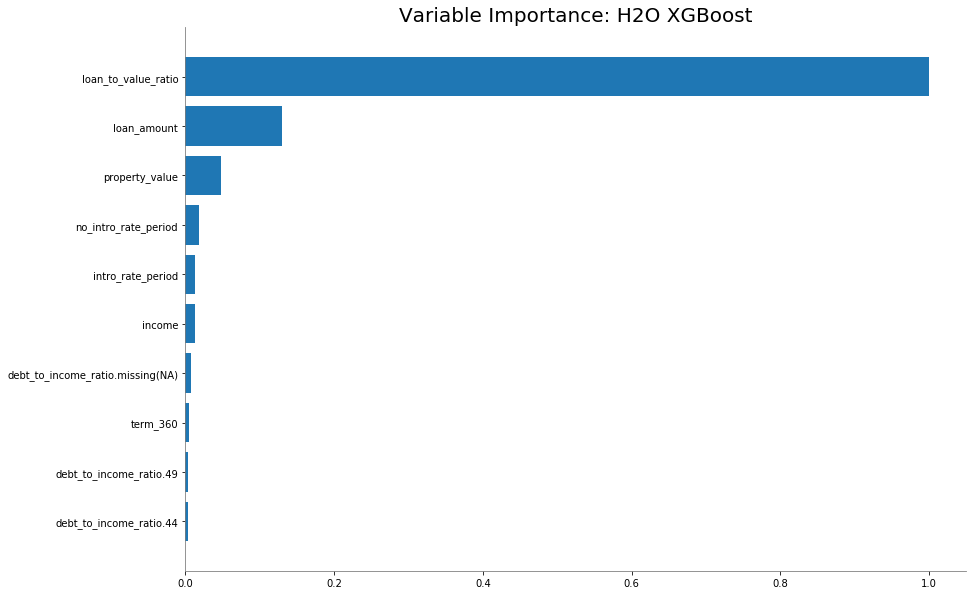

In [26]:
mxgb_default.varimp_plot()

In [27]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



debt_to_income_ratio.36,debt_to_income_ratio.37,debt_to_income_ratio.38,debt_to_income_ratio.39,debt_to_income_ratio.40,debt_to_income_ratio.41,debt_to_income_ratio.42,debt_to_income_ratio.43,debt_to_income_ratio.44,debt_to_income_ratio.45,debt_to_income_ratio.46,debt_to_income_ratio.47,debt_to_income_ratio.48,debt_to_income_ratio.49,debt_to_income_ratio.missing(NA),loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,term_360,conforming,BiasTerm
0.00911196,0.00957002,0.00951057,0.00570826,0.00458102,0.00405982,-0.00138583,-0.00478976,-0.00425497,-0.00215347,-0.00248693,0.16188,-0.00447179,-0.00331441,0.0568575,0.18039,0.915657,0.00738421,0.0124856,0.0219341,0.0192126,0.00879883,0.000740686,-2.34232
0.0051276,0.00531009,0.00569699,0.003568,0.00211337,0.00257075,-0.00209248,-0.00456561,-0.00526034,-0.00114102,-0.00230295,-0.00446121,-0.00507262,-0.00432285,-0.142033,-0.105315,-0.234703,0.00317395,0.0116985,-0.0724924,-0.0484933,0.0121205,0.00106583,-2.34232
0.00517984,0.00979473,0.0133708,-0.11117,0.00595055,0.0038499,-0.00421875,-0.00370598,-0.00433355,-0.0024131,-0.00300188,-0.00595518,-0.00431826,-0.00282391,0.0360462,0.1935,0.757238,-0.379165,-0.963861,0.0816174,0.0916389,0.00548605,0.0361246,-2.34232
0.00883663,0.00608445,0.00506677,0.00354987,0.00327951,0.00258813,-0.00263353,-0.00578364,-0.00392225,0.00208961,-0.000944535,-0.0042742,-0.000830556,-0.000150296,-0.058585,-0.0708975,-1.64722,0.00213583,0.0111082,-0.0998056,-0.0235145,0.0340333,0.00107173,-2.34232
0.00938741,0.00960191,0.00952552,0.00531121,0.00481278,0.00412135,-0.00214093,-0.00539828,-0.00566298,-0.0029112,0.0638257,-0.00667806,-0.00432909,-0.0043471,0.0572365,0.173605,0.862338,0.00680349,0.0127037,0.059685,0.0149366,0.00780654,0.00107525,-2.34232


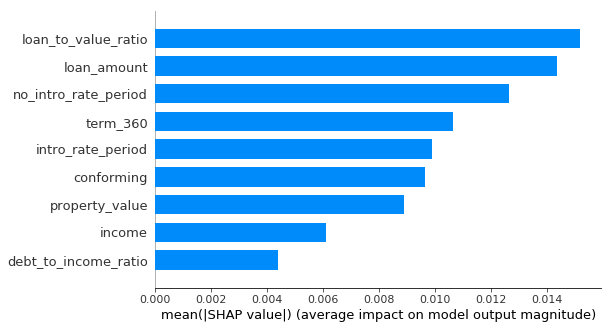

In [28]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

In [29]:
## Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.8066998332524288


In [30]:
## Get the AUC on the test set for MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.8005774218054201


In [31]:
mgbm_lucky = H2OGradientBoostingEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mgbm_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
mgbm_lucky

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1574453305437_28752


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,702.0,702.0,163227.0,0.0,5.0,4.85755,1.0,26.0,13.803419




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07743179565855872
RMSE: 0.27826569256478373
LogLoss: 0.2642003087499713
Mean Per-Class Error: 0.2572795306935953
AUC: 0.7999900426857534
pr_auc: 0.27350905280239346
Gini: 0.5999800853715067

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17676678282815358: 


,,0,1,Error,Rate
0,0,116828.0,28005.0,0.1934,(28005.0/144833.0)
1,1,5967.0,9538.0,0.3848,(5967.0/15505.0)
2,Total,122795.0,37543.0,0.2119,(33972.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.176767,0.359599,201.0
1,max f2,0.102464,0.517409,260.0
2,max f0point5,0.260638,0.310378,137.0
3,max accuracy,0.732632,0.903298,0.0
4,max precision,0.732632,0.500000,0.0
5,max recall,0.005764,1.000000,396.0
6,max specificity,0.732632,0.999986,0.0
7,max absolute_mcc,0.140944,0.304577,227.0
8,max min_per_class_accuracy,0.129726,0.736988,235.0
9,max mean_per_class_accuracy,0.095481,0.742720,266.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.410844,4.358199,4.358199,0.421446,0.482297,0.421446,0.482297,0.043599,0.043599,335.819867,335.819867
1,,2,0.020051,0.359156,3.723035,4.039925,0.360025,0.383225,0.390669,0.432653,0.037407,0.081006,272.303522,303.992547
2,,3,0.030068,0.328817,3.631602,3.903902,0.351183,0.344553,0.377515,0.403304,0.036375,0.117381,263.160207,290.390237
3,,4,0.040234,0.300820,3.305330,3.752659,0.319632,0.311497,0.362889,0.380107,0.033602,0.150984,230.532989,275.265866
4,,5,0.050001,0.287107,3.057412,3.616853,0.295658,0.293266,0.349757,0.363144,0.029861,0.180845,205.741171,261.685266
5,,6,0.100089,0.239009,2.626789,3.121389,0.254016,0.265519,0.301844,0.314289,0.131570,0.312415,162.678927,212.138911
6,,7,0.150245,0.216944,2.470177,2.903994,0.238871,0.226883,0.280822,0.285110,0.123896,0.436311,147.017651,190.399385
7,,8,0.200090,0.199008,2.230727,2.736275,0.215716,0.208906,0.264603,0.266127,0.111190,0.547501,123.072728,173.627530
8,,9,0.300316,0.136413,1.778635,2.416677,0.171998,0.164952,0.233697,0.232361,0.178265,0.725766,77.863508,141.667740
9,,10,0.400017,0.079791,1.080292,2.083592,0.104466,0.102112,0.201487,0.199897,0.107707,0.833473,8.029248,108.359172




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07761280297859131
RMSE: 0.2785907446032465
LogLoss: 0.26490408342734406
Mean Per-Class Error: 0.25770974651847633
AUC: 0.7983494856009958
pr_auc: 0.26951814530328216
Gini: 0.5966989712019917

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18428251526203598: 


,,0,1,Error,Rate
0,0,118844.0,25989.0,0.1794,(25989.0/144833.0)
1,1,6429.0,9076.0,0.4146,(6429.0/15505.0)
2,Total,125273.0,35065.0,0.2022,(32418.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184283,0.358948,197.0
1,max f2,0.095772,0.516675,271.0
2,max f0point5,0.260232,0.306318,137.0
3,max accuracy,0.729041,0.903286,0.0
4,max precision,0.397597,0.409342,65.0
5,max recall,0.004348,1.000000,398.0
6,max specificity,0.729041,0.999979,0.0
7,max absolute_mcc,0.130087,0.303824,241.0
8,max min_per_class_accuracy,0.128859,0.736859,242.0
9,max mean_per_class_accuracy,0.095772,0.742290,271.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.67 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.414621,4.145446,4.145446,0.400873,0.483199,0.400873,0.483199,0.041470,0.041470,314.544636,314.544636
1,,2,0.020001,0.358306,3.793224,3.969390,0.366812,0.383040,0.383848,0.433135,0.037923,0.079394,279.322405,296.939012
2,,3,0.030005,0.328897,3.694154,3.877626,0.357232,0.343064,0.374974,0.403105,0.036956,0.116350,269.415360,287.762555
3,,4,0.040003,0.302172,3.051352,3.671122,0.295072,0.313607,0.355005,0.380738,0.030506,0.146856,205.135200,267.112157
4,,5,0.050001,0.286814,3.083607,3.553648,0.298191,0.294302,0.343645,0.363455,0.030829,0.177685,208.360730,255.364803
5,,6,0.100007,0.240922,2.674899,3.114246,0.258668,0.265050,0.301154,0.314249,0.133763,0.311448,167.489902,211.424612
6,,7,0.150551,0.216661,2.411721,2.878393,0.233218,0.226608,0.278346,0.284826,0.121896,0.433344,141.172099,187.839279
7,,8,0.200002,0.198280,2.273231,2.728763,0.219826,0.208944,0.263877,0.266064,0.112415,0.545759,127.323148,172.876312
8,,9,0.300004,0.135533,1.792948,2.416825,0.173382,0.164706,0.233712,0.232278,0.179297,0.725056,79.294765,141.682463
9,,10,0.400011,0.079558,1.069252,2.079916,0.103399,0.101651,0.201132,0.199620,0.106933,0.831990,6.925245,107.991583




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.77954715,0.007919565,0.77099884,0.78277814,0.7816264,0.7722837,0.7900487
1,auc,0.7985897,0.0037221643,0.7938876,0.8035245,0.7986212,0.8005696,0.79634583
2,err,0.22045285,0.007919565,0.2290012,0.21722187,0.21837358,0.22771633,0.20995127
3,err_count,7069.4,257.9686,7323.0,6912.0,6998.0,7350.0,6764.0
4,f0point5,0.2851003,0.008780547,0.27742383,0.2967566,0.2824957,0.27713722,0.29168817
5,f1,0.35989317,0.007372635,0.35360578,0.37163636,0.3573921,0.35458377,0.3622478
6,f2,0.48815873,0.0071608224,0.48746654,0.49705753,0.4863298,0.49210295,0.47783694
7,lift_top_group,4.163268,0.17052779,4.196332,4.162738,4.388257,3.9091146,4.159899
8,logloss,0.2649132,0.003988884,0.26537076,0.2690446,0.26154977,0.26015896,0.26844183
9,max_per_class_error,0.359125,0.021194763,0.34798178,0.3586445,0.3596578,0.3362919,0.39304897



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-29 16:34:29,2 min 38.649 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-11-29 16:34:30,2 min 38.942 sec,10.0,0.292902,0.309124,0.791145,0.256753,3.899612,0.227569
2,,2019-11-29 16:34:30,2 min 39.266 sec,20.0,0.290715,0.302359,0.791279,0.256907,3.900963,0.227781
3,,2019-11-29 16:34:30,2 min 39.602 sec,30.0,0.288948,0.297087,0.791912,0.258024,3.918314,0.234330
4,,2019-11-29 16:34:31,2 min 39.985 sec,40.0,0.287364,0.292397,0.792007,0.258017,3.954298,0.242375
5,,2019-11-29 16:34:31,2 min 40.327 sec,50.0,0.286048,0.288526,0.792177,0.258247,3.943884,0.230326
6,,2019-11-29 16:34:31,2 min 40.667 sec,60.0,0.284935,0.285278,0.792417,0.258807,3.928376,0.230407
7,,2019-11-29 16:34:32,2 min 41.004 sec,70.0,0.284084,0.282760,0.792712,0.259729,4.035847,0.229253
8,,2019-11-29 16:34:32,2 min 41.333 sec,80.0,0.283309,0.280472,0.793123,0.261020,4.181522,0.229465
9,,2019-11-29 16:34:32,2 min 41.664 sec,90.0,0.282680,0.278614,0.793338,0.261647,4.171235,0.229234



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,59516.632812,1.000000,0.760373
1,property_value,7230.669434,0.121490,0.092378
2,loan_amount,5810.950195,0.097636,0.074240
3,debt_to_income_ratio,2599.998779,0.043685,0.033217
4,no_intro_rate_period,1478.842896,0.024848,0.018893
5,intro_rate_period,1103.913696,0.018548,0.014103
6,conforming,224.852768,0.003778,0.002873
7,term_360,200.898499,0.003376,0.002567
8,income,106.232391,0.001785,0.001357


In [33]:
## Get the AUC on the test set
perf_mgbm_lucky = mgbm_lucky.model_performance(test)
print(perf_mgbm_lucky.auc())

0.8048216876312628


In [34]:
## Get the AUC on the test set
perf_cv_mgbm_lucky = mgbm_lucky.model_performance(xval=True)
print(perf_cv_mgbm_lucky.auc())

0.7983494856009958


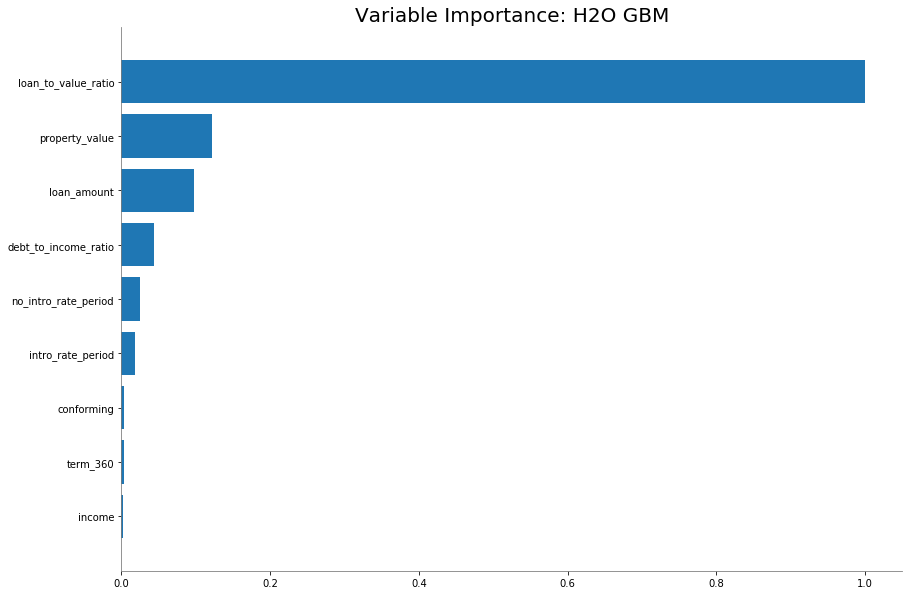

In [35]:
mgbm_lucky.varimp_plot()

In [36]:
shap_values_mgbm_lucky, expected_value_mgbm_lucky = get_shapley(mgbm_lucky, train, X)

First 5 rows of contributions:



loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,BiasTerm
0.174612,1.1049,0.020589,0.0347712,0.188874,0.00195159,0.207933,0.0151856,0.00371838,-2.71392
-0.0166786,0.118469,0.00677569,0.0203994,-0.0399508,0.000231364,-0.0949988,0.0175095,0.00242328,-2.71392
0.243729,0.960448,-0.175354,-0.728392,0.20499,0.000375473,-0.0449783,0.0130028,0.00734114,-2.71392
-0.00331823,-1.14314,0.00455021,0.0177224,-0.202809,-0.000898286,-0.0924707,0.0284902,0.00433091,-2.71392
0.181505,1.14146,0.0194719,0.0331262,0.196758,0.00103827,0.107835,0.0148527,0.00344808,-2.71392


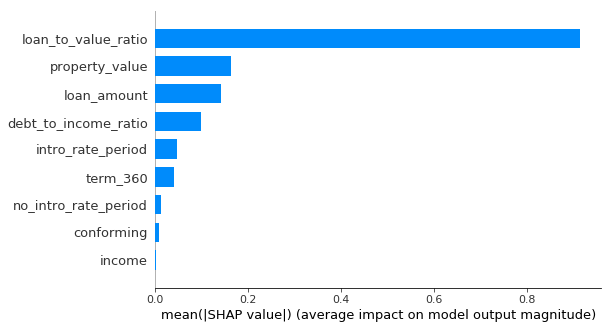

In [37]:
shap.summary_plot(shap_values_mgbm_lucky, X, plot_type="bar")

In [38]:
mxgb_lucky = H2OXGBoostEstimator(
  # monotonicity constraints
  monotone_constraints=mono_constraints,
    
  # more trees is better if the learning rate is small enough 
  # here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  # smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  # early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  # sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  # sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  # fix a random number generator seed for reproducibility
  seed = SEED,                                                             

  # score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

mxgb_lucky.train(x=X, y=Y, training_frame=train, fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [39]:
mxgb_lucky

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1574453305437_29554


Model Summary: 


,,number_of_trees
0,,910.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07701600790606884
RMSE: 0.27751758125579873
LogLoss: 0.2624298338404633
Mean Per-Class Error: 0.25458445615664904
AUC: 0.803493414858995
pr_auc: 0.2815592608839217
Gini: 0.6069868297179899

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17962662361207463: 


,,0,1,Error,Rate
0,0,116888.0,27945.0,0.1929,(27945.0/144833.0)
1,1,5868.0,9637.0,0.3785,(5868.0/15505.0)
2,Total,122756.0,37582.0,0.2109,(33813.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.179627,0.363064,199.0
1,max f2,0.098712,0.520321,264.0
2,max f0point5,0.264667,0.315057,133.0
3,max accuracy,0.711405,0.903317,4.0
4,max precision,0.839057,1.000000,0.0
5,max recall,0.002404,1.000000,398.0
6,max specificity,0.839057,1.000000,0.0
7,max absolute_mcc,0.127090,0.307339,238.0
8,max min_per_class_accuracy,0.132497,0.739175,234.0
9,max mean_per_class_accuracy,0.096556,0.745416,266.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.417822,4.699892,4.699892,0.454489,0.488445,0.454489,0.488445,0.047017,0.047017,369.989176,369.989176
1,,2,0.020120,0.357447,3.838047,4.266565,0.371147,0.381224,0.412585,0.434535,0.038826,0.085843,283.804739,326.656517
2,,3,0.030005,0.336887,3.529659,4.023789,0.341325,0.344611,0.389108,0.404910,0.034892,0.120735,252.965851,302.378881
3,,4,0.040433,0.304673,3.432586,3.871314,0.331938,0.316540,0.374364,0.382118,0.035795,0.156530,243.258580,287.131443
4,,5,0.050119,0.280693,3.122958,3.726690,0.301996,0.290128,0.360378,0.364341,0.030248,0.186778,212.295753,272.669045
5,,6,0.100114,0.241432,2.639445,3.183745,0.255240,0.260593,0.307874,0.312531,0.131957,0.318736,163.944497,218.374504
6,,7,0.150095,0.219647,2.418159,2.928804,0.233841,0.229402,0.283221,0.284849,0.120864,0.439600,141.815948,192.880435
7,,8,0.201506,0.201793,2.236818,2.752258,0.216305,0.212348,0.266149,0.266352,0.114995,0.554595,123.681844,175.225788
8,,9,0.300029,0.137374,1.774023,2.431026,0.171552,0.168690,0.235085,0.234282,0.174782,0.729378,77.402348,143.102625
9,,10,0.399999,0.079841,1.079975,2.093364,0.104436,0.102835,0.202432,0.201430,0.107965,0.837343,7.997503,109.336351




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07738927897634577
RMSE: 0.2781892862357315
LogLoss: 0.26387988252513783
Mean Per-Class Error: 0.2564173253812301
AUC: 0.8004726951110299
pr_auc: 0.2738374407815143
Gini: 0.6009453902220598

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18462771848056392: 


,,0,1,Error,Rate
0,0,117665.0,27168.0,0.1876,(27168.0/144833.0)
1,1,6093.0,9412.0,0.393,(6093.0/15505.0)
2,Total,123758.0,36580.0,0.2074,(33261.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.184628,0.361409,203.0
1,max f2,0.098302,0.518183,270.0
2,max f0point5,0.254189,0.310282,144.0
3,max accuracy,0.793053,0.903298,1.0
4,max precision,0.793053,0.500000,1.0
5,max recall,0.001837,1.000000,399.0
6,max specificity,0.868249,0.999993,0.0
7,max absolute_mcc,0.121701,0.305398,252.0
8,max min_per_class_accuracy,0.132068,0.737246,245.0
9,max mean_per_class_accuracy,0.096783,0.743583,272.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.414017,4.261493,4.261493,0.412095,0.492555,0.412095,0.492555,0.042631,0.042631,326.149307,326.149307
1,,2,0.020001,0.356657,3.980305,4.120943,0.384903,0.381620,0.398503,0.437105,0.039794,0.082425,298.030483,312.094279
2,,3,0.030024,0.333674,3.603602,3.948245,0.348475,0.344296,0.381803,0.406124,0.036117,0.118542,260.360219,294.824517
3,,4,0.040003,0.304451,3.386694,3.808164,0.327500,0.316847,0.368257,0.383853,0.033796,0.152338,238.669429,280.816388
4,,5,0.050057,0.282010,2.745639,3.594759,0.265509,0.293314,0.347620,0.365669,0.027604,0.179942,174.563892,259.475867
5,,6,0.100032,0.241380,2.645595,3.120562,0.255834,0.260601,0.301764,0.313178,0.132215,0.312157,164.559530,212.056164
6,,7,0.150002,0.218708,2.469100,2.903543,0.238767,0.229008,0.280778,0.285139,0.123380,0.435537,146.910024,190.354327
7,,8,0.200009,0.201686,2.250578,2.740287,0.217635,0.212674,0.264991,0.267021,0.112544,0.548081,125.057801,174.028669
8,,9,0.300054,0.136667,1.788297,2.422871,0.172932,0.168872,0.234296,0.234296,0.178910,0.726991,78.829725,142.287113
9,,10,0.399999,0.079841,1.068629,2.084495,0.103339,0.102644,0.201575,0.201401,0.106804,0.833796,6.862907,108.449537




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7863903,0.010988334,0.7881356,0.7970459,0.7838108,0.7689996,0.79395974
1,auc,0.80069286,0.0038618864,0.795895,0.8060988,0.80041325,0.80243653,0.79862064
2,err,0.2136097,0.010988334,0.21186441,0.20295411,0.21618922,0.23100041,0.2060403
3,err_count,6851.0,379.98288,6775.0,6458.0,6928.0,7456.0,6638.0
4,f0point5,0.28919962,0.010695111,0.2848448,0.3041489,0.28353167,0.27749422,0.29597852
5,f1,0.36208183,0.0077865473,0.35592738,0.37386078,0.35780495,0.35657576,0.3662402
6,f2,0.4846119,0.009004507,0.47428426,0.48503146,0.4848028,0.49869654,0.48024437
7,lift_top_group,4.2095327,0.24693921,4.0011535,4.287933,4.5004783,3.9091146,4.348985
8,logloss,0.2638886,0.0039325864,0.26451865,0.26773283,0.26058802,0.2591123,0.26749122
9,max_per_class_error,0.37308568,0.03171389,0.390625,0.39504236,0.36492267,0.32084155,0.39399683



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-11-29 17:02:37,24 min 30.007 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-11-29 17:02:40,24 min 33.158 sec,10.0,0.467737,0.630555,0.793332,0.264321,3.965292,0.212751
2,,2019-11-29 17:02:43,24 min 36.140 sec,20.0,0.439589,0.578667,0.793902,0.263755,4.033126,0.212825
3,,2019-11-29 17:02:46,24 min 39.197 sec,30.0,0.415205,0.535292,0.794079,0.264031,4.067558,0.212981
4,,2019-11-29 17:02:49,24 min 42.231 sec,40.0,0.394101,0.498587,0.794410,0.264523,4.067480,0.212869
5,,2019-11-29 17:02:52,24 min 45.489 sec,50.0,0.375888,0.467259,0.794923,0.264935,4.086953,0.212794
6,,2019-11-29 17:02:55,24 min 48.324 sec,60.0,0.360226,0.440334,0.795671,0.265774,4.123654,0.209096
7,,2019-11-29 17:02:58,24 min 50.951 sec,70.0,0.346987,0.417404,0.795821,0.266254,4.123848,0.207880
8,,2019-11-29 17:03:00,24 min 53.776 sec,80.0,0.335778,0.397676,0.795972,0.266710,4.147580,0.208522
9,,2019-11-29 17:03:03,24 min 56.264 sec,90.0,0.326226,0.380465,0.796189,0.267093,4.131502,0.207169



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio,506584.656250,1.000000,0.750745
1,property_value,62967.011719,0.124297,0.093315
2,loan_amount,56120.156250,0.110781,0.083169
3,no_intro_rate_period,9531.649414,0.018816,0.014126
4,intro_rate_period,8710.229492,0.017194,0.012908
5,income,6210.718750,0.012260,0.009204
6,debt_to_income_ratio.missing(NA),4853.781738,0.009581,0.007193
7,term_360,3486.404785,0.006882,0.005167
8,debt_to_income_ratio.49,2516.916504,0.004968,0.003730
9,debt_to_income_ratio.44,2449.398438,0.004835,0.003630



See the whole table with table.as_data_frame()


In [40]:
## Get the AUC on the test set
perf_mxgb_lucky = mxgb_lucky.model_performance(test)
print(perf_mxgb_lucky.auc())

0.8066861352844112


In [41]:
## Get the AUC on the test set
perf_cv_mxgb_lucky = mxgb_lucky.model_performance(xval=True)
print(perf_cv_mxgb_lucky.auc())

0.8004726951110299


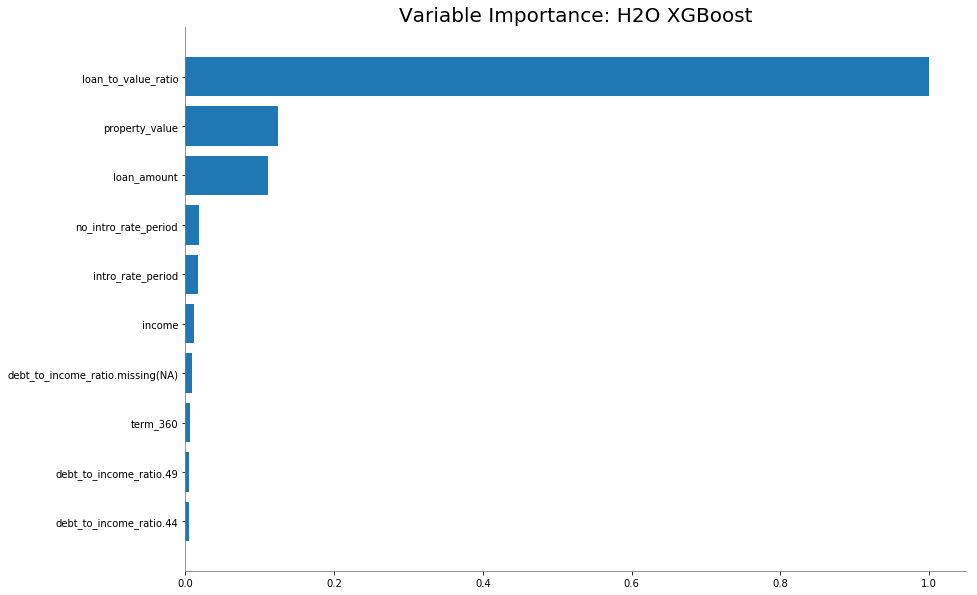

In [42]:
mxgb_lucky.varimp_plot()

In [43]:
shap_values_mxgb_lucky, expected_value_mxgb_lucky = get_shapley(mxgb_lucky, train, X)

First 5 rows of contributions:



debt_to_income_ratio.36,debt_to_income_ratio.37,debt_to_income_ratio.38,debt_to_income_ratio.39,debt_to_income_ratio.40,debt_to_income_ratio.41,debt_to_income_ratio.42,debt_to_income_ratio.43,debt_to_income_ratio.44,debt_to_income_ratio.45,debt_to_income_ratio.46,debt_to_income_ratio.47,debt_to_income_ratio.48,debt_to_income_ratio.49,debt_to_income_ratio.missing(NA),loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,term_360,conforming,BiasTerm
0.00721195,0.00752148,0.00710939,0.00256573,0.00255814,0.00125272,-0.00249805,-0.00570337,-0.00512401,-0.00302219,-0.00254717,0.164733,-0.00493677,-0.00488697,0.0435707,0.121207,0.838677,0.00650043,0.0115296,0.105901,0.0138011,0.00821675,0.000952683,-2.30543
0.00460719,0.00414738,0.0046185,0.00185967,0.00132013,0.000944674,-0.0028797,-0.00514952,-0.00575637,-0.00162844,-0.00252848,-0.00492276,-0.00445089,-0.00410369,-0.122934,-0.0927287,-0.260613,0.00274991,0.0101585,-0.059241,-0.0430691,0.0109945,0.000863529,-2.30543
0.00505841,0.00822121,0.00901524,-0.0559356,0.00307151,0.000763005,-0.00366775,-0.00418238,-0.00507685,-0.00232851,-0.00335328,-0.00524264,-0.00526625,-0.00357243,0.0415753,0.181817,0.666333,-0.35653,-0.913402,0.174333,0.051477,0.00547688,0.012603,-2.30543
0.00501756,0.00526704,0.00423576,0.00198947,0.00209208,0.000922582,-0.00319397,-0.00581011,-0.00237221,3.09026e-05,-0.00102551,-0.00404585,-0.00110453,0.00240764,-0.0653178,-0.0538802,-1.58342,0.00187224,0.0135887,-0.269439,-0.0301012,0.0348443,0.00114699,-2.30543
0.00726572,0.0074469,0.00720605,0.00250919,0.00250917,0.0012247,-0.00266511,-0.00661295,-0.00693069,-0.0032767,0.0818361,-0.00635115,-0.00563385,-0.005474,0.0441694,0.122598,0.800192,0.00638614,0.0112265,0.14153,0.0115088,0.00755691,0.00100957,-2.30543


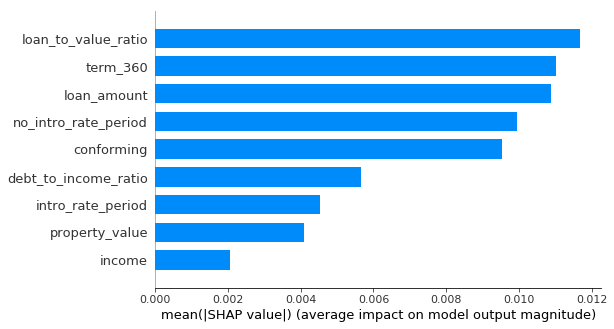

In [44]:
shap.summary_plot(shap_values_mxgb_lucky, X, plot_type="bar")

In [37]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : list(range(1,30,2))}
#hyper_params = {max_depth = [4,6,8,12,16,20]} ##faster for larger datasets

#Build initial GBM Model
mgbm_grid = H2OGradientBoostingEstimator(
        # monotonicity constraints
        monotone_constraints=mono_constraints,
        # more trees is better if the learning rate is small enough 
        # here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        # smaller learning rate is better
        # since we have learning_rate_annealing, we can afford to start with a 
        # bigger learning rate
        learn_rate=0.05,
        # learning rate annealing: learning_rate shrinks by 1% after every tree 
        # (use 1.00 to disable, but then lower the learning_rate)
        learn_rate_annealing = 0.99,
        # sample 80% of rows per tree
        sample_rate = 0.8,
        # sample 80% of columns per split
        col_sample_rate = 0.8,
        # fix a random number generator seed for reproducibility
        seed = 1234,
        # score every 10 trees to make early stopping reproducible 
        # (it depends on the scoring interval)
        score_tree_interval = 10, 
        # early stopping once the validation AUC doesn't improve by at least 0.01% for 
        # 5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid = H2OGridSearch(mgbm_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid.train(x=X, 
           y=Y,
           training_frame = train)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [38]:
print(grid)

     max_depth            model_ids              logloss
0            9   depth_grid_model_5   0.2644513283679875
1           23  depth_grid_model_12  0.26445507753804176
2           13   depth_grid_model_7   0.2644936784745442
3           29  depth_grid_model_15   0.2644970530568461
4           27  depth_grid_model_14   0.2644972252486081
5           25  depth_grid_model_13  0.26449725805246754
6           21  depth_grid_model_11   0.2644987384058637
7           19  depth_grid_model_10   0.2644987390062237
8           11   depth_grid_model_6  0.26450111481721583
9           15   depth_grid_model_8  0.26450258972308943
10          17   depth_grid_model_9   0.2645025904283923
11           5   depth_grid_model_3   0.2645201859658451
12           7   depth_grid_model_4  0.26452037598455697
13           3   depth_grid_model_2  0.26494316948535157
14           1   depth_grid_model_1    0.268411512458191



In [39]:
## sort the grid models by decreasing AUC
sorted_grid = grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid)

     max_depth            model_ids                 auc
0           23  depth_grid_model_12  0.7995415376073483
1            9   depth_grid_model_5  0.7995375202593249
2           27  depth_grid_model_14  0.7994364410844891
3           13   depth_grid_model_7  0.7994354809999866
4           29  depth_grid_model_15  0.7994344262874895
5           25  depth_grid_model_13  0.7994245275312726
6           21  depth_grid_model_11  0.7994228992617999
7           19  depth_grid_model_10  0.7994228992617999
8           17   depth_grid_model_9  0.7994226131512745
9           15   depth_grid_model_8  0.7994205720810905
10          11   depth_grid_model_6  0.7994180899331237
11           7   depth_grid_model_4    0.79939241502027
12           5   depth_grid_model_3  0.7993713372467302
13           3   depth_grid_model_2  0.7986685709767618
14           1   depth_grid_model_1  0.7933555849096295



In [41]:
max_depths = sorted_grid.sorted_metric_table()['max_depth'][0:5]
new_max = int(max(max_depths, key=int))
new_min = int(min(max_depths, key=int))

print("MaxDepth", new_max)
print("MinDepth", new_min)

MaxDepth 29
MinDepth 9


In [42]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : list(range(new_min,new_max+1,1)),
                'sample_rate': [x/100. for x in range(20,101)],
                'col_sample_rate' : [x/100. for x in range(20,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(20,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,int(math.log(train.nrow,2)-1)+1)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,13)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_runtime_secs': 3600,  ## limit the runtime to 60 minutes
                   'max_models': 100,  ## build no more than 100 models
                   'seed' : 1234,
                   'stopping_rounds' : 5,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-3
                   }

In [43]:
gbm_final_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # smaller learning rate is better
                    # since we have learning_rate_annealing, we can afford to start with a 
                    # bigger learning rate
                    learn_rate=0.05,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)
            
#Build grid search with previously made GBM and hyper parameters
final_grid = H2OGridSearch(gbm_final_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'final_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
final_grid.train(x=X, 
           y=Y,
           ## early stopping based on timeout (no model should take more than 1 hour - modify as needed)
           max_runtime_secs = 3600, 
           training_frame = train)

print(final_grid)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
      col_sample_rate col_sample_rate_change_per_level  \
0                0.92                             1.04   
1                0.69                             0.97   
2                0.85                             1.07   
3                 0.7                             1.08   
4                0.96                             1.04   
5                0.75                             0.99   
6                0.92                             1.06   
7                0.49                             1.04   
8                0.63                              1.0   
9                0.55                             1.05   
10               0.97                             0.96   
11               0.87                              0.9   
12               0.91                             1.02   
13                0.6                              1.0   
14               0.92                            

[100 rows x 13 columns]



In [44]:
# Sort the grid models by AUC
sorted_final_grid = final_grid.get_grid(sort_by='auc',decreasing=True)

print(sorted_final_grid)

      col_sample_rate col_sample_rate_change_per_level  \
0                0.92                             1.04   
1                0.69                             0.97   
2                0.85                             1.07   
3                 0.7                             1.08   
4                0.96                             1.04   
5                0.92                             1.06   
6                0.75                             0.99   
7                0.55                             1.05   
8                0.49                             1.04   
9                0.63                              1.0   
10               0.97                             0.96   
11               0.92                             1.06   
12               0.87                              0.9   
13                0.6                              1.0   
14               0.91                             1.02   
15                0.9                              1.1   
16            

[100 rows x 13 columns]



In [45]:
#Get the best model from the list (the model name listed at the top of the table)
best_model = h2o.get_model(sorted_final_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(test)
print(performance_best_model.auc())

0.8041853514702857


In [46]:
## Depth 10 is usually plenty of depth for most datasets, but you never know
hyper_params = {'max_depth' : list(range(1,30,2))}
#hyper_params = {max_depth = [4,6,8,12,16,20]} ##faster for larger datasets

#Build initial GBM Model
mxgb_grid = H2OXGBoostEstimator(
        # monotonicity constraints
        monotone_constraints=mono_constraints,
        # more trees is better if the learning rate is small enough 
        # here, use "more than enough" trees - we have early stopping
        ntrees=10000,
        # smaller learning rate is better
        # since we have learning_rate_annealing, we can afford to start with a 
        # bigger learning rate
        learn_rate=0.05,
        # learning rate annealing: learning_rate shrinks by 1% after every tree 
        # (use 1.00 to disable, but then lower the learning_rate)
        # learn_rate_annealing = 0.99,
        # sample 80% of rows per tree
        sample_rate = 0.8,
        # sample 80% of columns per split
        col_sample_rate = 0.8,
        # fix a random number generator seed for reproducibility
        seed = 1234,
        # score every 10 trees to make early stopping reproducible 
        # (it depends on the scoring interval)
        score_tree_interval = 10, 
        # early stopping once the validation AUC doesn't improve by at least 0.01% for 
        # 5 consecutive scoring events
        stopping_rounds = 5,
        stopping_metric = "AUC",
        stopping_tolerance = 1e-4)

#Build grid search with previously made GBM and hyper parameters
grid_xgb = H2OGridSearch(mxgb_grid,hyper_params,
                         grid_id = 'depth_grid',
                         search_criteria = {'strategy': "Cartesian"})


#Train grid search
grid_xgb.train(x=X, 
           y=Y,
           training_frame = train)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [47]:
print(grid_xgb)

     max_depth            model_ids              logloss
0           27  depth_grid_model_14   0.2617663118012617
1           13   depth_grid_model_7  0.26178409615625603
2           19  depth_grid_model_10   0.2617888476640759
3           25  depth_grid_model_13  0.26179157594492375
4           21  depth_grid_model_11  0.26179837904243275
5           29  depth_grid_model_15  0.26180415330527895
6           15   depth_grid_model_8   0.2618188716163921
7           23  depth_grid_model_12   0.2618312834795874
8           17   depth_grid_model_9  0.26187325505875947
9            9   depth_grid_model_5  0.26187728842537317
10          11   depth_grid_model_6  0.26188114897112585
11           7   depth_grid_model_4  0.26190412938557245
12           5   depth_grid_model_3  0.26210692905358224
13           3   depth_grid_model_2  0.26266358504059956
14           1   depth_grid_model_1   0.2647673821525523



In [48]:
## sort the grid models by decreasing AUC
sorted_grid_xgb = grid_xgb.get_grid(sort_by='auc',decreasing=True)
print(sorted_grid_xgb)

     max_depth            model_ids                 auc
0           27  depth_grid_model_14  0.8060478951290614
1           25  depth_grid_model_13  0.8060162176841807
2           19  depth_grid_model_10  0.8059947996951679
3           29  depth_grid_model_15  0.8059880468188058
4           21  depth_grid_model_11  0.8059325082014138
5           23  depth_grid_model_12  0.8058866481353287
6           15   depth_grid_model_8  0.8058128616780764
7           13   depth_grid_model_7  0.8057914588295425
8           17   depth_grid_model_9  0.8057751601037205
9           11   depth_grid_model_6  0.8055900828863973
10           9   depth_grid_model_5  0.8054615912060694
11           7   depth_grid_model_4  0.8051864060949531
12           5   depth_grid_model_3  0.8046618045229523
13           3   depth_grid_model_2  0.8032582651825669
14           1   depth_grid_model_1  0.7986697287781097



In [50]:
max_depths_xgb = sorted_grid_xgb.sorted_metric_table()['max_depth'][0:5]
new_max_xgb = int(max(max_depths_xgb, key=int))
new_min_xgb = int(min(max_depths_xgb, key=int))

print("MaxDepth", new_max_xgb)
print("MinDepth", new_min_xgb)

MaxDepth 29
MinDepth 19
